In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import operator
from sklearn.preprocessing import StandardScaler

In [2]:
data = np.load("../predict_iri_data.npy")
iri = data[:, -1]
scaler = StandardScaler()
scaler.fit(data[:, :-1])
data = scaler.transform(data[:, :-1])
print(data.shape)
df = pd.DataFrame(data, columns=["acc_mean", "acc_var", "acc_min", "acc_max", "acc_range", 
                                "rp_mean", "rp_var", "rp_min", "rp_max", "rp_range"])
df['IRI'] = iri
df.head()

(400, 10)


,acc_mean,acc_var,acc_min,acc_max,acc_range,rp_mean,rp_var,rp_min,rp_max,rp_range,IRI
0,-0.228708,1.582894,-0.264516,0.221266,0.294606,-1.708449,0.484462,-1.717903,0.903299,1.312785,17.587740
1,0.794234,0.069730,0.277389,0.294662,0.016809,-0.461547,-0.354336,0.407997,-0.387307,-0.399517,10.197539
2,0.124003,-0.597442,0.529208,-0.554576,-0.658614,-0.929110,-0.509866,0.777791,-0.775592,-0.780538,4.894511
3,-0.022025,0.727781,0.099822,0.110726,0.008948,2.094727,0.026368,-0.544515,0.490661,0.519873,14.179559
4,-0.184902,-0.668512,0.555631,-0.013546,-0.339755,0.236065,-0.481257,0.613464,-0.595188,-0.607230,3.912838


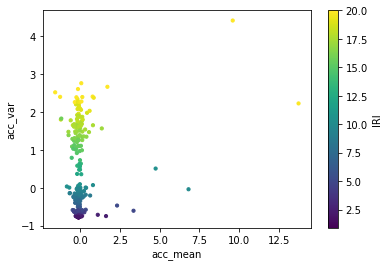

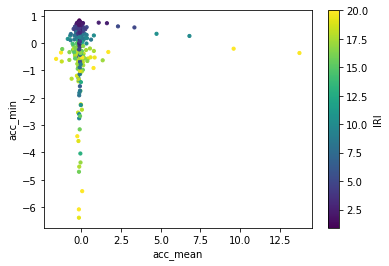

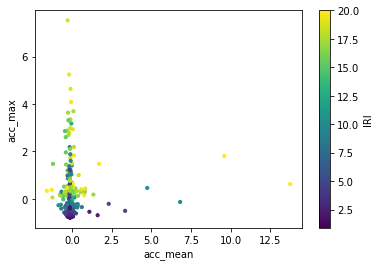

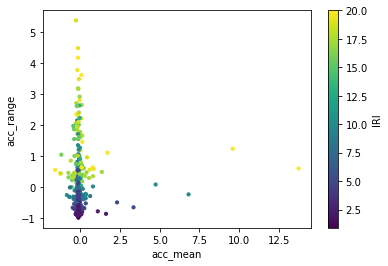

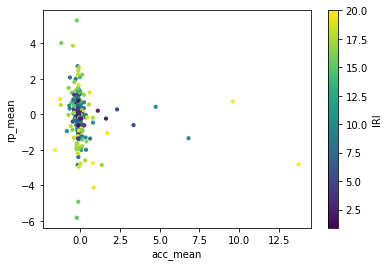

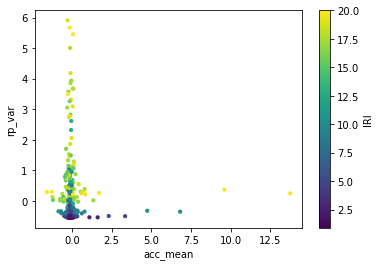

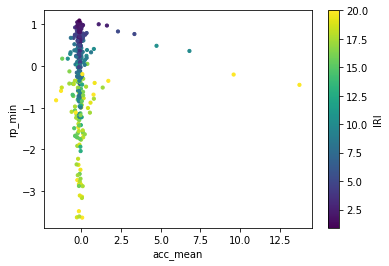

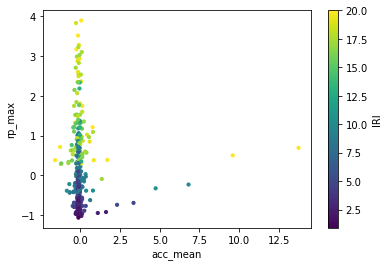

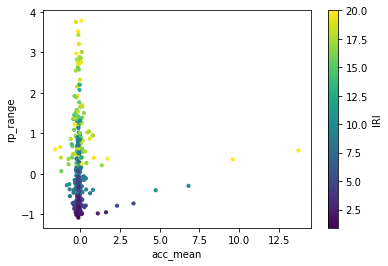

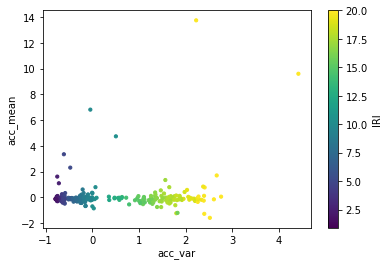

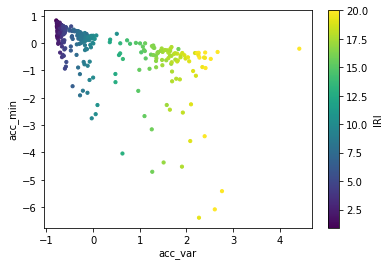

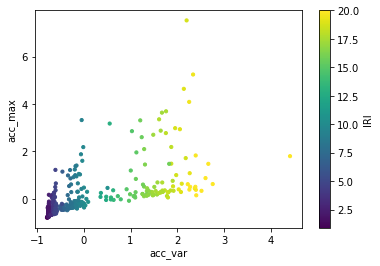

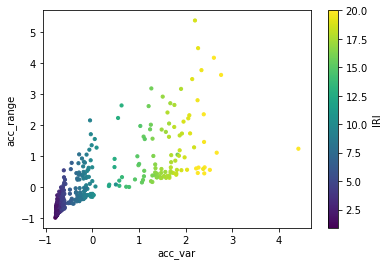

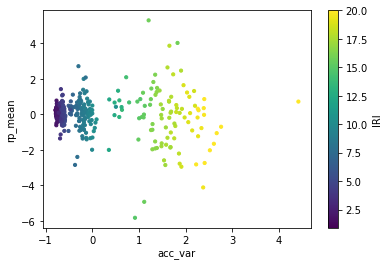

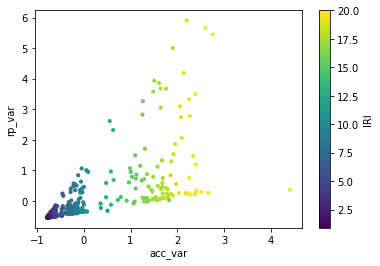

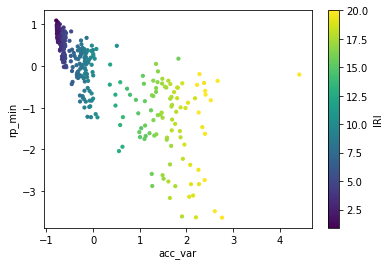

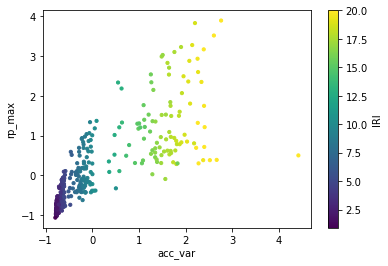

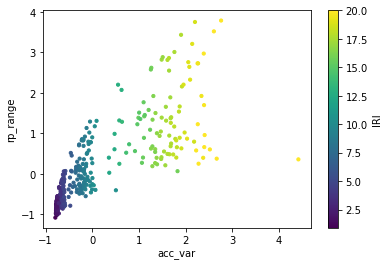

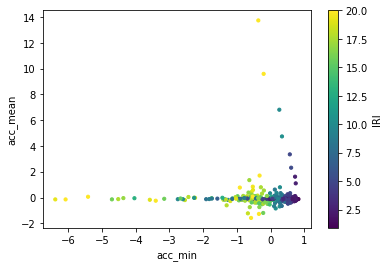

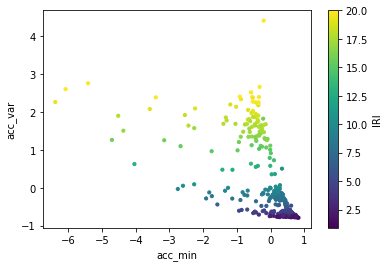

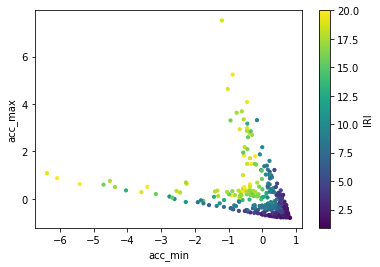

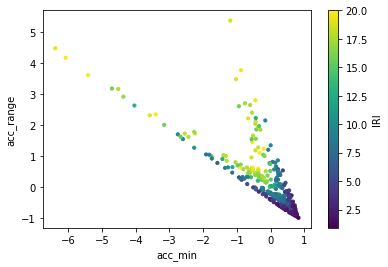

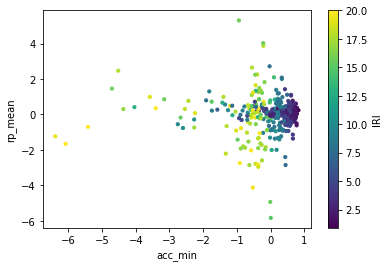

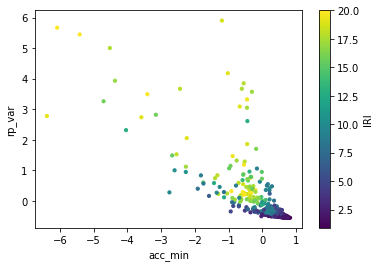

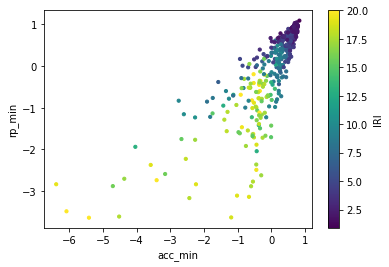

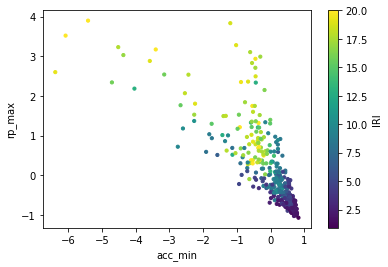

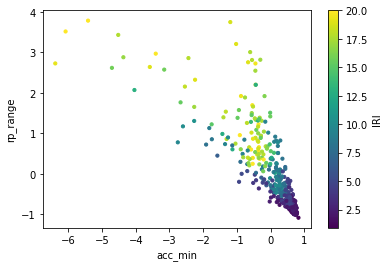

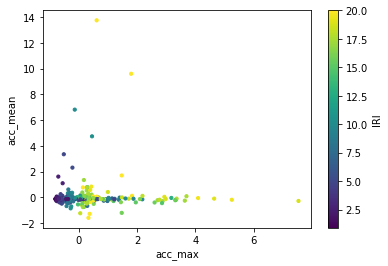

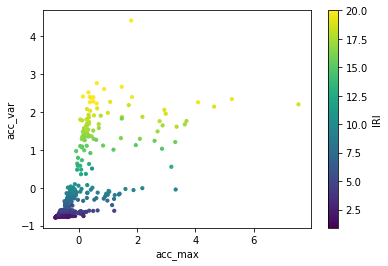

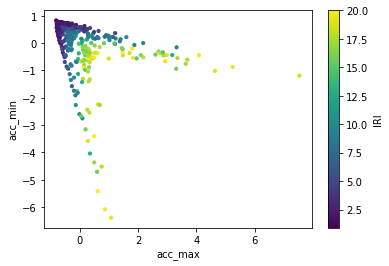

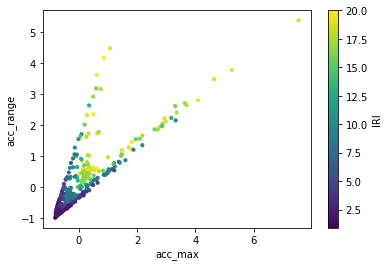

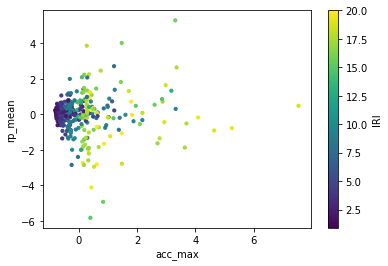

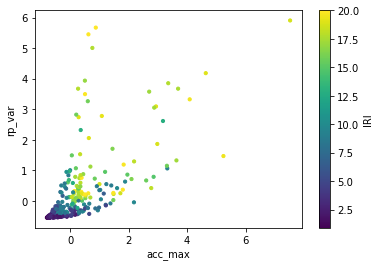

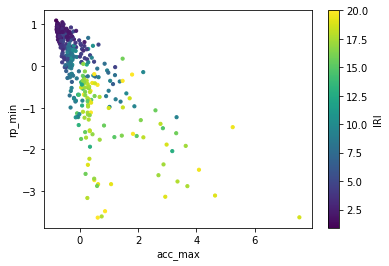

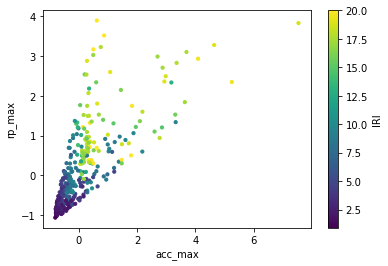

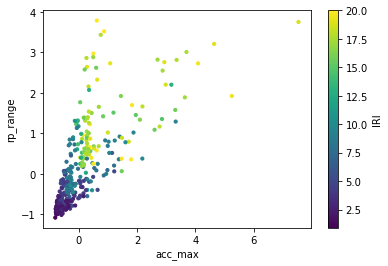

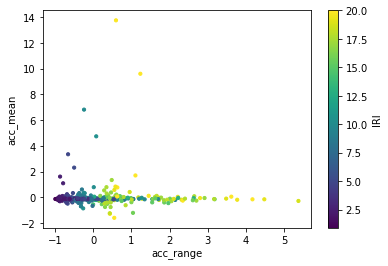

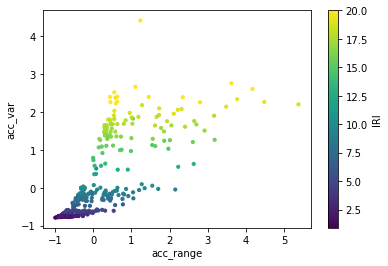

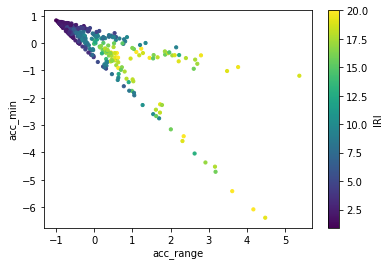

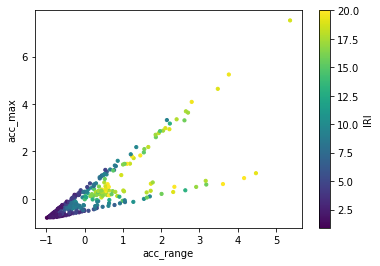

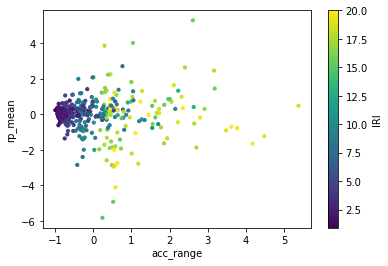

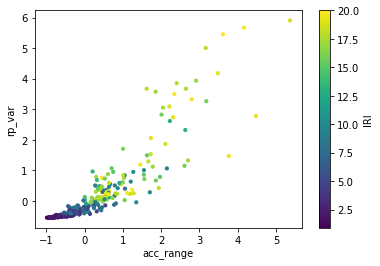

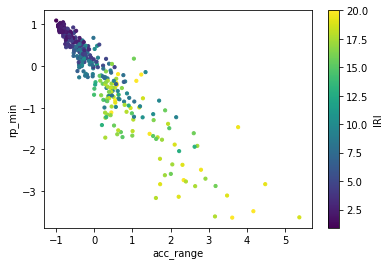

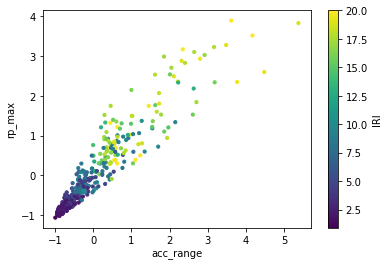

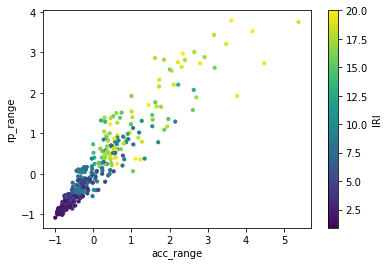

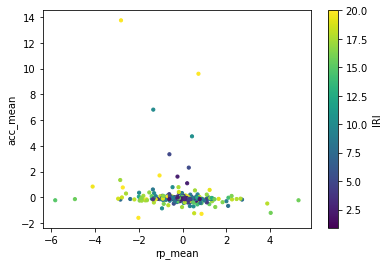

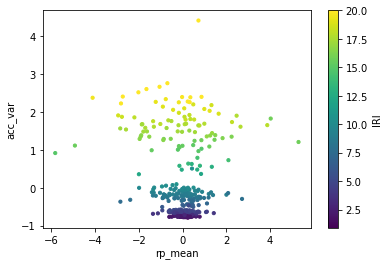

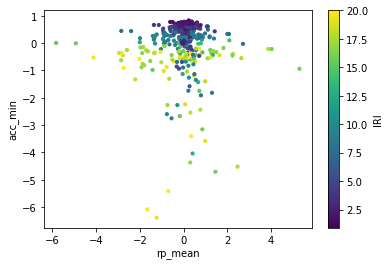

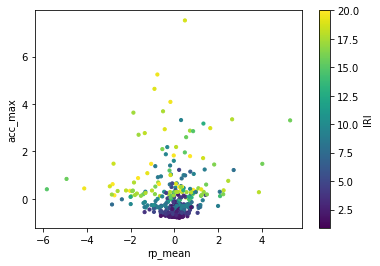

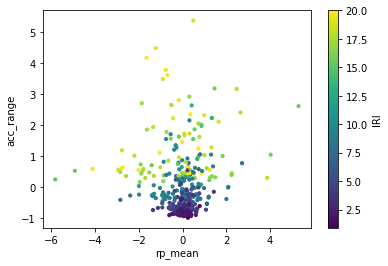

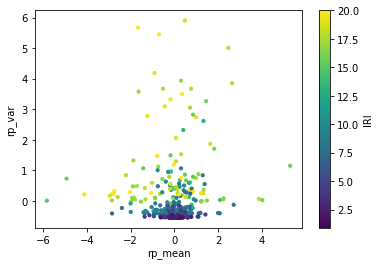

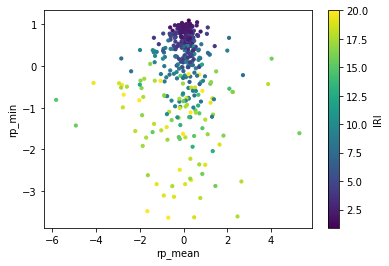

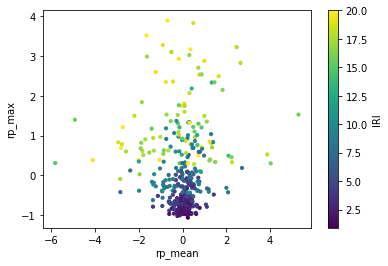

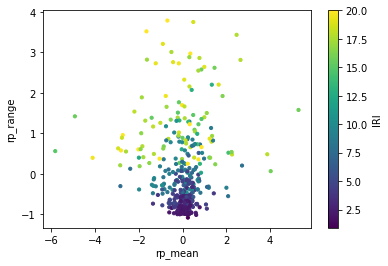

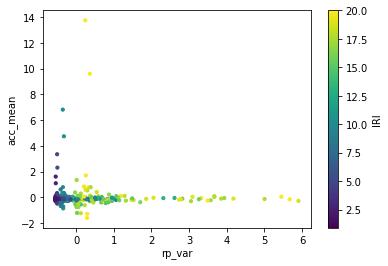

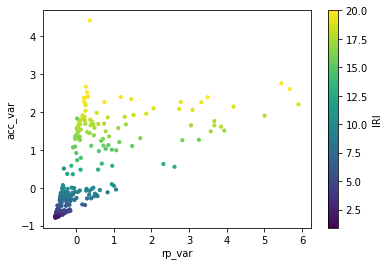

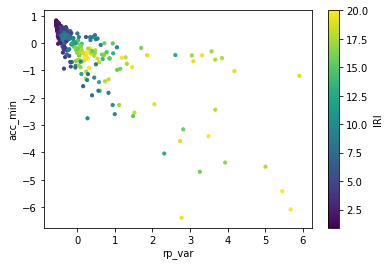

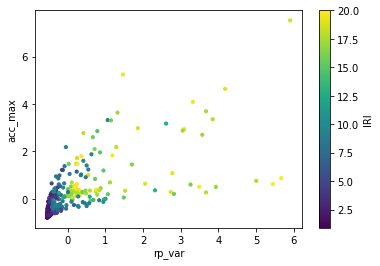

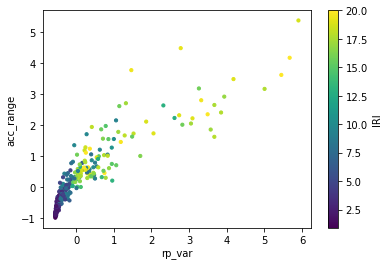

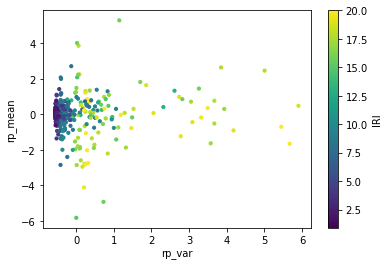

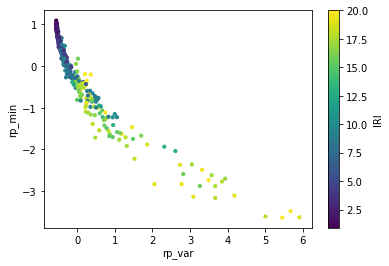

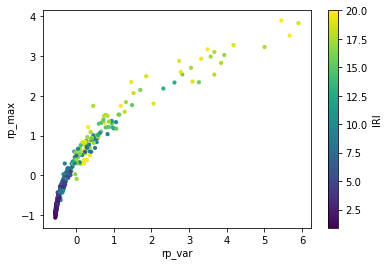

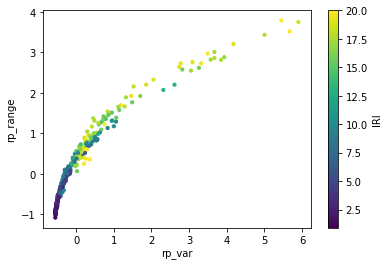

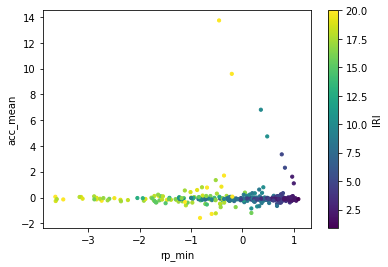

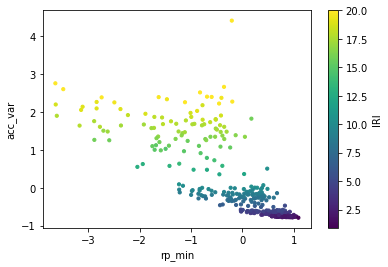

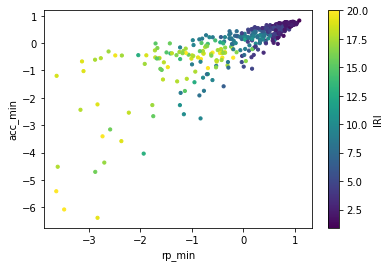

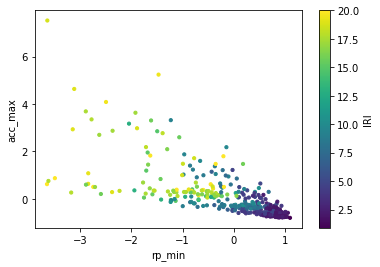

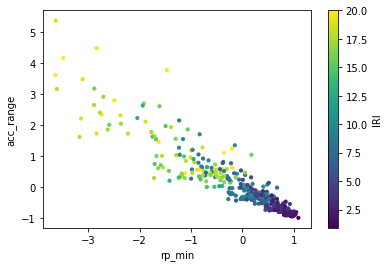

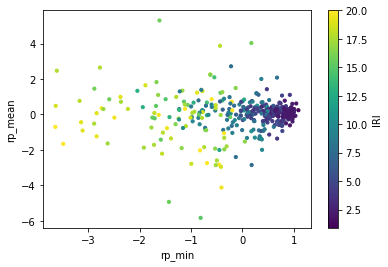

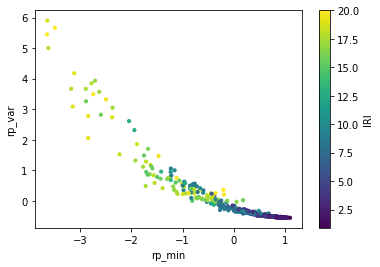

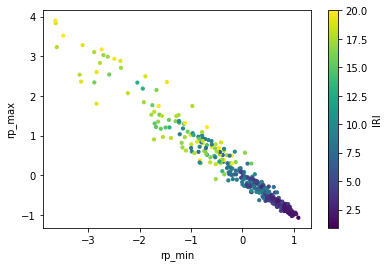

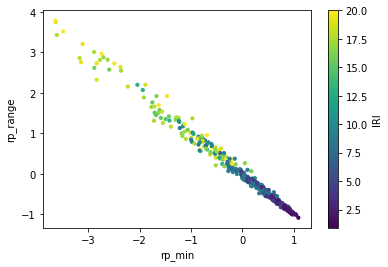

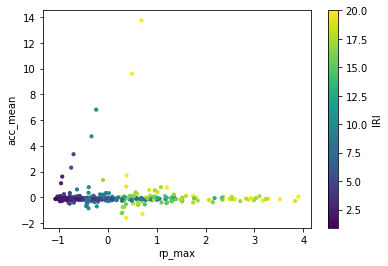

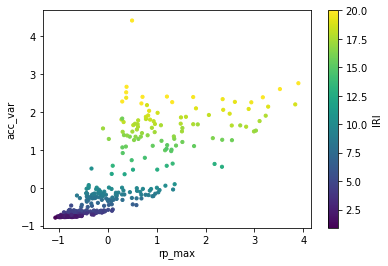

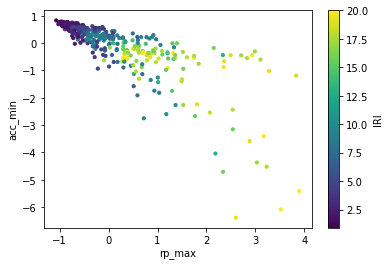

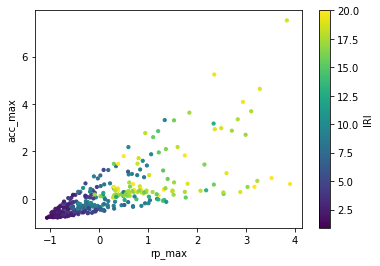

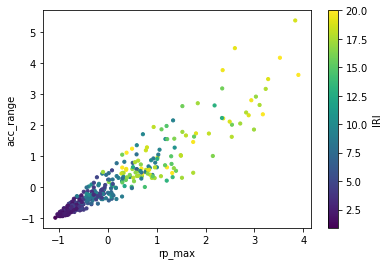

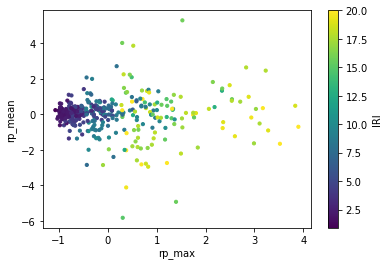

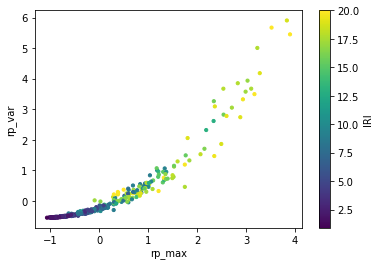

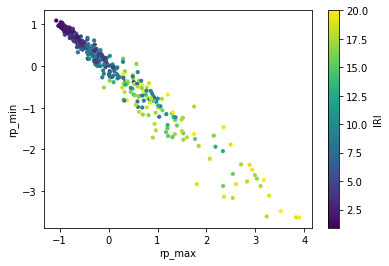

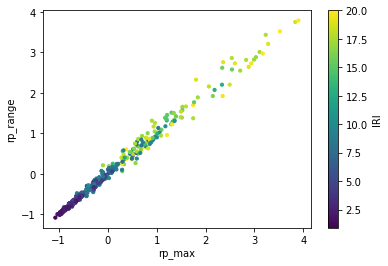

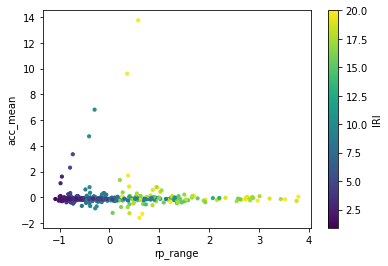

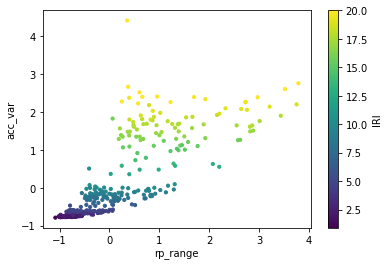

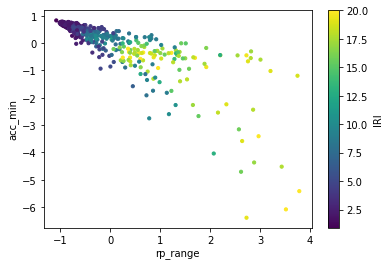

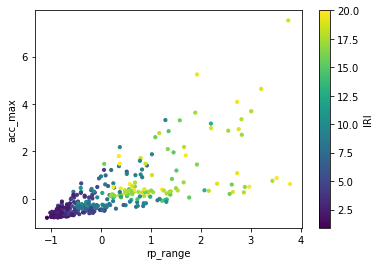

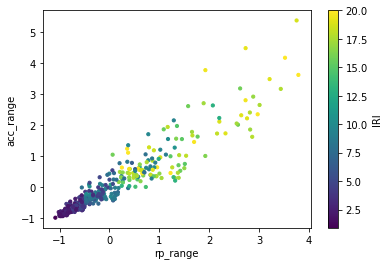

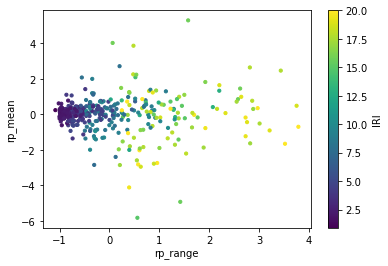

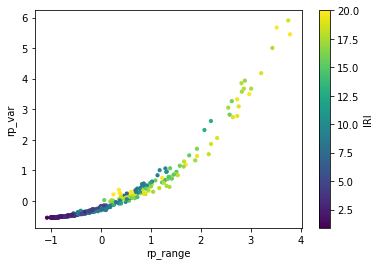

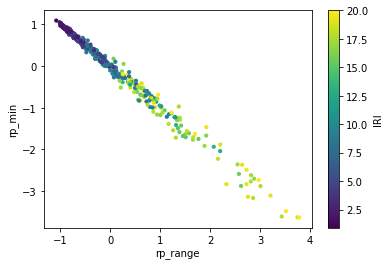

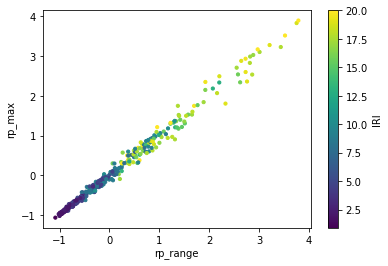

In [3]:
for i in df.columns[:-1]:
    for j in df.columns[:-1]:
        if i != j:
            plt.scatter(df[i], df[j], c = df['IRI'], s = 10)
            plt.ylabel(j)
            plt.xlabel(i)
            cb = plt.colorbar()
            cb.set_label('IRI')
            plt.show()


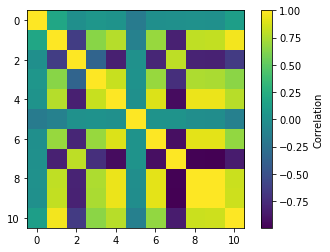

Index(['acc_mean', 'acc_var', 'acc_min', 'acc_max', 'acc_range', 'rp_mean',
       'rp_var', 'rp_min', 'rp_max', 'rp_range', 'IRI'],
      dtype='object')

In [4]:
plt.imshow(df.corr())
cb = plt.colorbar()
cb.set_label("Correlation")
plt.show()
df.columns

We can safely say that means are useless and acc_var as well as the mins/maxs  are the most correlated with the IRI.

Degree: 1, rmse train: 1.5575817788863116, rmse test: 1.353157016149917
Degree: 2, rmse train: 0.7186033151029264, rmse test: 0.6743071307153103
Degree: 3, rmse train: 0.5502035532268515, rmse test: 0.46701325217596074
Degree: 4, rmse train: 0.3906577955711828, rmse test: 0.3520737029813135


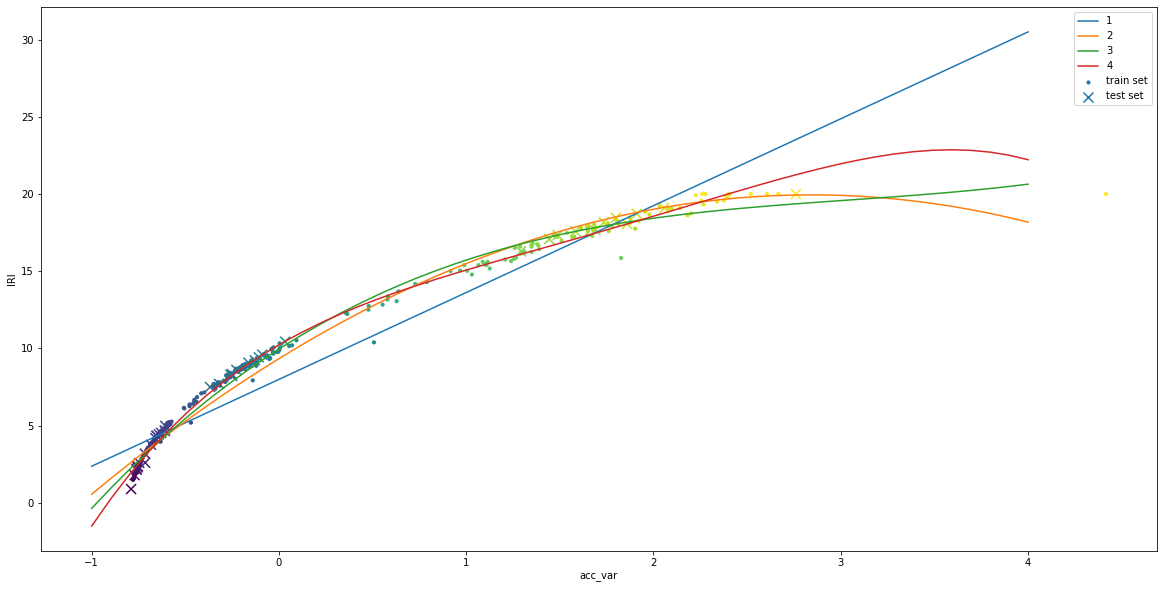

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data[:, 1], df['IRI'], test_size=0.1, random_state=42)
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

line_x = np.linspace(-1, 4)[:, np.newaxis]

plt.figure(figsize = (20, 10))
plt.scatter(X_train, y_train, label = "train set", c = y_train, s = 10)
plt.scatter(X_test, y_test, label = "test set", c = y_test, s = 100, marker = 'x')
#plt.xlim((-5, 50))
#plt.ylim((0, 25))
plt.xlabel("acc_var")
plt.ylabel("IRI")

for i in range(1, 5):
    
    X_train, X_test, y_train, y_test = train_test_split(data[:, 1], df['IRI'], test_size=0.3, random_state=42)
    X_train = X_train[:, np.newaxis]
    X_test = X_test[:, np.newaxis]
    
    poly_features = PolynomialFeatures(degree=i)

    X_train_poly = poly_features.fit_transform(X_train)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    y_train_predicted = poly_model.predict(X_train_poly)
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    #sort_axis = operator.itemgetter(0)
    #sorted_zip = sorted(zip(X_train,y_train_predicted), key=sort_axis)
    #X_train, y_train_predicted = zip(*sorted_zip)
    
    line_y = poly_model.predict(poly_features.fit_transform(line_x))
    
    plt.plot(line_x, line_y, label = str(i))
    
    print("Degree: {}, rmse train: {}, rmse test: {}".format(i, rmse_train, rmse_test))
    
plt.legend()
plt.show()

Well, as long as it's not linear... Shall we say 4? The lower the value is, the more important the precision, since a road with IRI 15+ is bad anyways, we don't need to tell them that

Let's see some multinomial results. Because of the fanning out effect we project it first to a ine in the middle

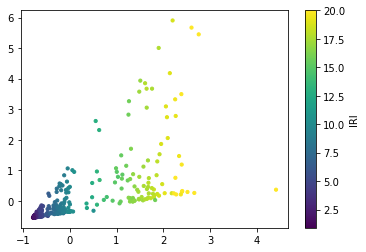

In [6]:
plt.scatter(df['acc_var'], df['rp_var'], c = df['IRI'], s = 10)
cb = plt.colorbar()
cb.set_label('IRI')
plt.show()

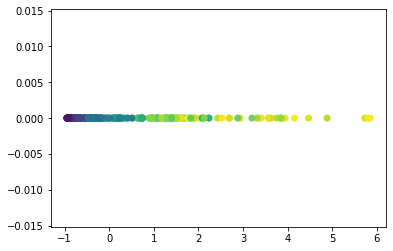

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

X = np.concatenate((df['acc_var'].values[:, np.newaxis], df['rp_var'].values[:, np.newaxis]), axis = 1)

X_1D = pca.fit_transform(X)

plt.scatter(X_1D, np.zeros(len(X_1D)), c = df['IRI'])

#Hmmm... not my favourite
#Let's find a "custom direction"

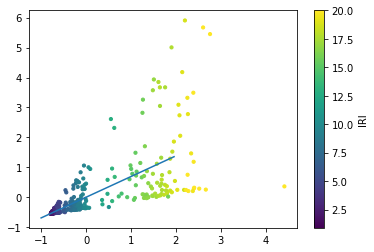

In [8]:
X_train = X[:, 0][:, np.newaxis]

X_train_poly = poly_features.fit_transform(X_train)

linear_model = LinearRegression()
linear_model.fit(X_train, X[:, 1][:, np.newaxis])
line_y = linear_model.coef_*line_x[:-20] + linear_model.intercept_
plt.scatter(df['acc_var'], df['rp_var'], c = df['IRI'], s = 10)
plt.plot(line_x[:-20], line_y)
cb = plt.colorbar()
cb.set_label('IRI')
plt.show()


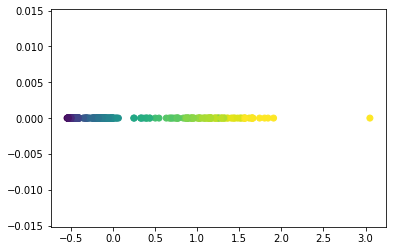

In [15]:
W = np.concatenate((linear_model.coef_[0], linear_model.intercept_))
Z = W @ X.T

plt.scatter(Z, np.zeros(len(Z)), c = df['IRI'])
#Much better

Here we can define decision boundaries or just use this as a scale